In [1]:
!pip show shap
!pip install --upgrade matplotlib
!pip install --upgrade seaborn
!pip install phik
!pip install --upgrade scikit-learn
!pip install --upgrade numba
!pip install --upgrade shap

     |████████████████████████████████| 8.3 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 321 kB 96.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 83.5 MB/s eta 0:00:01
     |████████████████████████████████| 19.5 MB 90.0 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2 which is incompatible.
     |████████████████████████████████| 294 kB 1.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phik 
import shap
import sklearn
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split  
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from phik.report import plot_correlation_matrix
from phik import report
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier


In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка данных

In [4]:
customer = pd.read_csv('/datasets/market_file.csv', sep = ',')
money = pd.read_csv('/datasets/market_money.csv', decimal = ',')
time = pd.read_csv('/datasets/market_time.csv', sep = ',')
profit = pd.read_csv('/datasets/money.csv', sep = ';')

Вывод: Данные представлены загружены.

### Предобработка данных

In [5]:
all = [customer, money, time, profit]

In [6]:
for a in all:
    a.columns = a.columns.str.lower().str.replace(' ', '_')

#### customer

In [7]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [8]:
customer.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [9]:
customer['тип_сервиса'] = customer['тип_сервиса'].replace('стандартт', 'стандарт')
customer['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [10]:
customer['покупательская_активность'] = customer['покупательская_активность'].str.lower()
customer['покупательская_активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [11]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [12]:
customer['популярная_категория'] = customer['популярная_категория'].replace('косметика и аксесуары', 'косметика и аксессуары')
customer['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [13]:
print(customer.isna().sum())

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64


In [14]:
customer.duplicated().sum()

0

#### money

In [15]:
money['выручка'] = money['выручка'].astype('float')

In [16]:
money.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [18]:
money.duplicated().sum()

0

In [19]:
money = money.drop_duplicates().reset_index(drop = True)

In [20]:
money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

#### time

In [21]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [22]:
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [23]:
time.duplicated().sum()

0

In [24]:
time.isna().sum()

id        0
период    0
минут     0
dtype: int64

#### profit

In [25]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [26]:
profit['прибыль'] = profit['прибыль'].str.replace(',', '.')

In [27]:
profit['прибыль'] = profit['прибыль'].astype('float')

In [28]:
profit.duplicated().sum()

0

In [29]:
profit.isna().sum()

id         0
прибыль    0
dtype: int64

#### Вывод: Для начала привела названия столбцов всех данных к нижнему регистру. В таблице customer произведена замена типа сервиса 'стандартт' на 'стандарт' из-за опечатки в данных, исправлены 'Косметика и аксесуары' в 'косметика и аксессуары'. В столбце 'покупательская_активность'  все уникальные значения привела к нижнему регистру для удобства восприятия. Пропущенных данных и дубликатов не обнаружено. В таблице money обнаружены 5 явных дубликатов, которые в последствие удалены. Пропущенных данных не выявлено. В таблице time сделана замена данных в столбце 'Период' - 'предыдцщий_месяц' на 'предыдущий_месяц' из-за опечатки в данных. Пропуски и дубликаты в таблице не обнаружены. В таблице  profit в столбце 'Прибыль' поменяла тип данных. Пропущенных данных и дубликатов не обнаружено.

### Исследовательский анализ данных

#### customer

In [30]:
customer.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

In [31]:
### функция для количественных признаков
def box_hist_plot(df, feature, title):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
    fig.suptitle(f"{title}", fontsize = 16)
    sns.histplot(df[feature], kde = True, bins = 20, ax = ax[0])
    ax[0].set_title('Гистограмма', fontsize = 15)
    ax[0].set_xlabel(title)
    
    sns.boxplot(df[feature], ax = ax[1])
    ax[1].set_title('Диаграмма размаха', fontsize = 15)
    ax[1].set_xlabel(None)
    plt.show  

In [32]:
### функция для категориальных признаков
def bar_plotter(df, feature, title, xticks=None, xlabel=None):
    fig = plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=df[feature].value_counts().index,
                     y=df[feature].value_counts())
    if xticks:
        ax.set(xticklabels=xticks)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel)
    plt.ylabel('Число пользователей')
    plt.show()

##### Покупательская активность

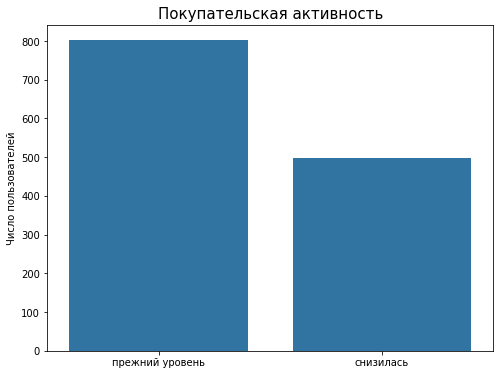

In [33]:
bar_plotter(customer, 'покупательская_активность', 'Покупательская активность')

По графику видно, что покупателей с низкой покупательской активностью меньше, чем покупателей с прежним уровнем активности. Что говорит о хорошей работе компании.

##### Тип сервиса

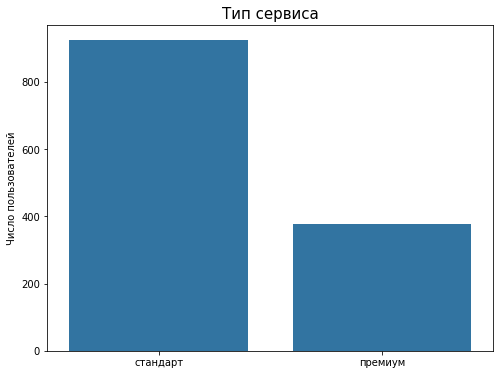

In [34]:
bar_plotter(customer, 'тип_сервиса', 'Тип сервиса')

Премиум сервис у меньшего количества покупателей (около 30% покупателей).

##### Длительность

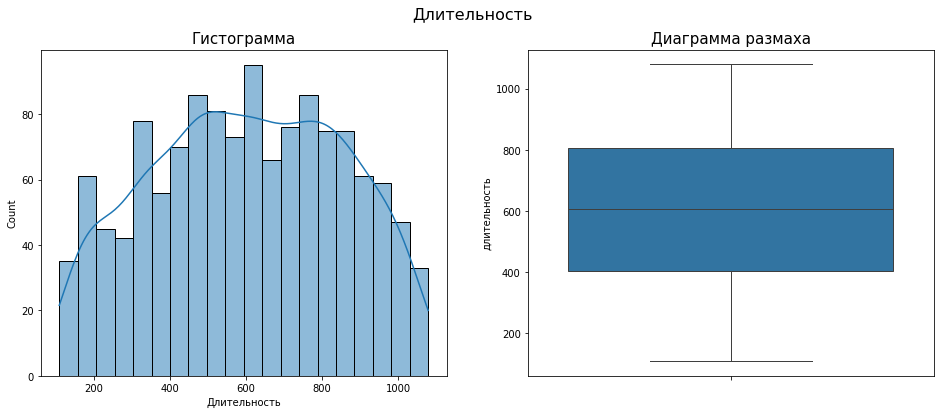

In [35]:
box_hist_plot(customer, 'длительность', 'Длительность')

Согласно гистограмме все покупатели зарегистрированы более 100 дней, среднее количество покупателей зарегестрировано около 600 дней, встречаются и те, кто зарегистрирован более 1000 дней, но их не много. Распределение нормальное.

##### Акционные_покупки

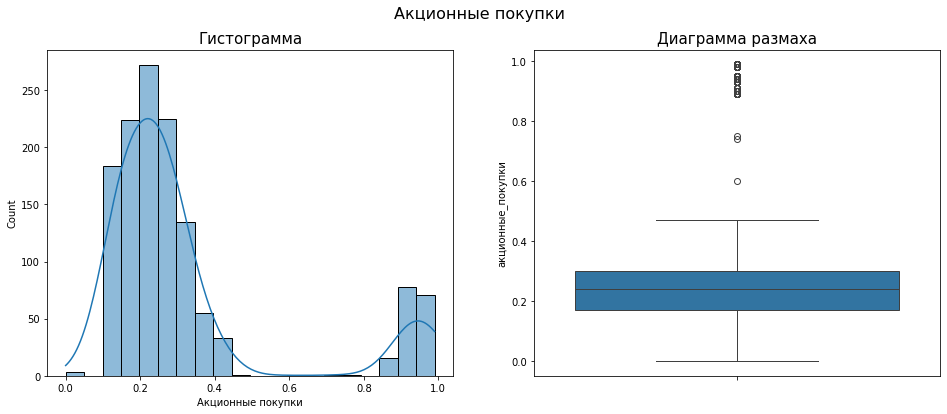

In [36]:
box_hist_plot(customer, 'акционные_покупки', 'Акционные покупки')

Распределение ненормальное. Согласно графикам видно, что в большинстве случаев продукты по акции при покупке составляют  20-30% от заказа.

##### Популярная_категория

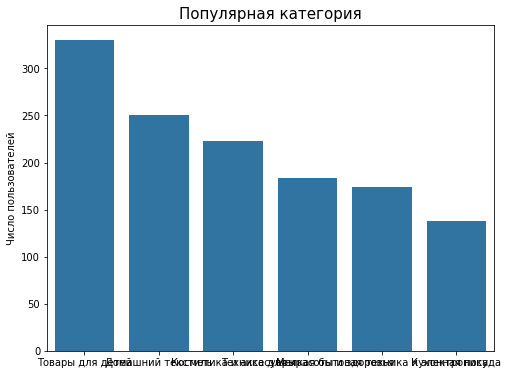

In [37]:
bar_plotter(customer, 'популярная_категория', 'Популярная категория')

Ожидаемо, что больше всего покупают товары для детей, Домашний текстиль и косметику/аксессуары. Самая плохо продаваемая категория среди представленных - кухонная посуда.

##### Средний_просмотр_категорий_за_визит

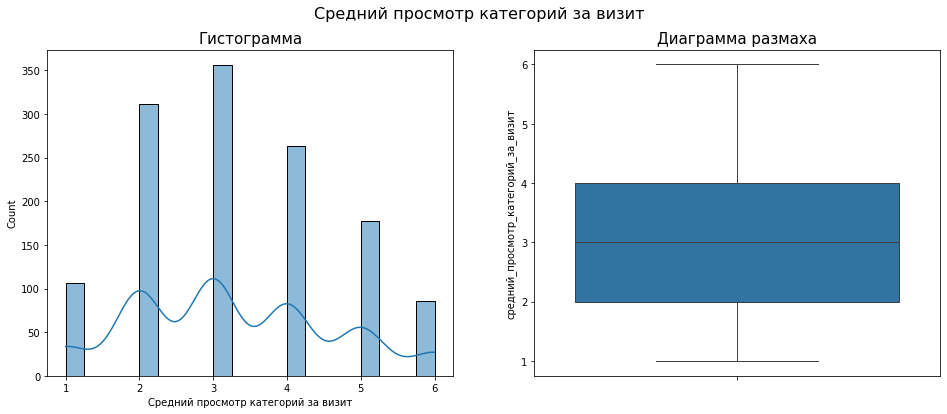

In [38]:
box_hist_plot(customer, 'средний_просмотр_категорий_за_визит', 'Средний просмотр категорий за визит')

В среднем 2 - 3 категории покупатель смотрит за визит в течение последнего месяца. Одну категорию вероятно смотрят те, кто знает, что именно надо купить, а 6 категорий интересны для тех, кто зашел "посмотреть" - их меньше всех.

##### Неоплаченные_продукты_штук_квартал

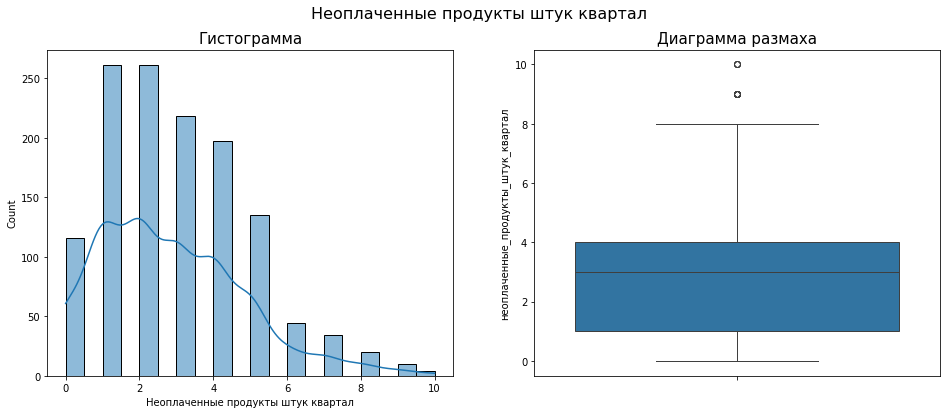

In [39]:
box_hist_plot(customer,'неоплаченные_продукты_штук_квартал', 'Неоплаченные продукты штук квартал')

Самое большее количество неоплаченных продуктов составляет 1-3 единицы за квартал.

##### Ошибка_сервиса

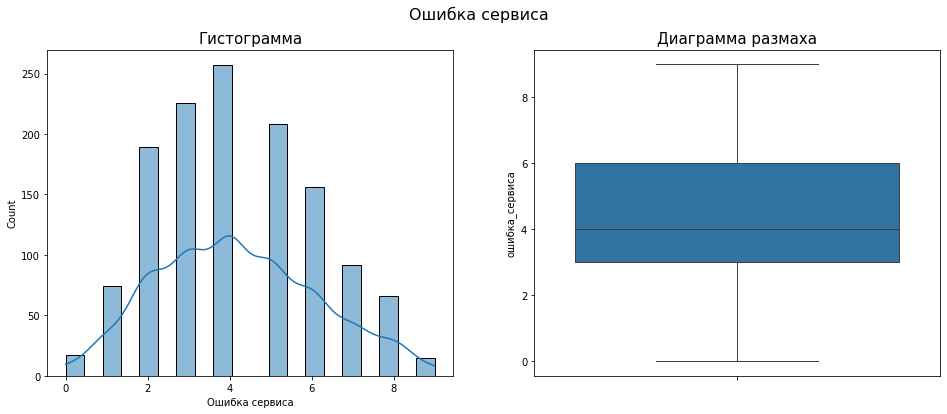

In [40]:
box_hist_plot(customer, 'ошибка_сервиса', 'Ошибка сервиса')

Сбои в количестве 4 раз коснулись покупателя во время посещения сайта - самый распространенный показатель ошибок сервиса. Расстраивает, что есть показатели и в 8-9 ошибок. Количество посетителей с такими данными мало, но это знак на то, что над техническим сопровождением надо работать, так как ошибки сервиса раздражают обычно покупателя. Таким образом теряются клиенты и отзывы о работе сервиса не будут положительными.

##### Страниц_за_визит

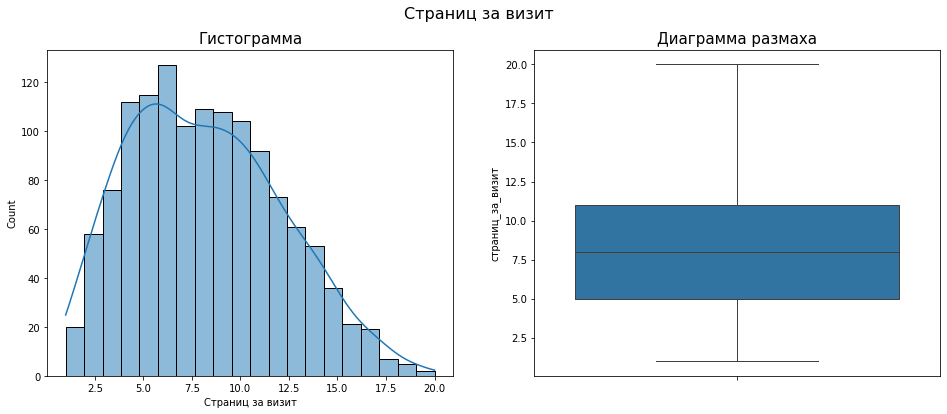

In [41]:
box_hist_plot(customer, 'страниц_за_визит', 'Страниц за визит')


В среднем покупатель за один визит просматривает от 3 до 12 страниц в течение последнего месяца.

#### money

In [42]:
money.describe()

id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

In [43]:
money.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

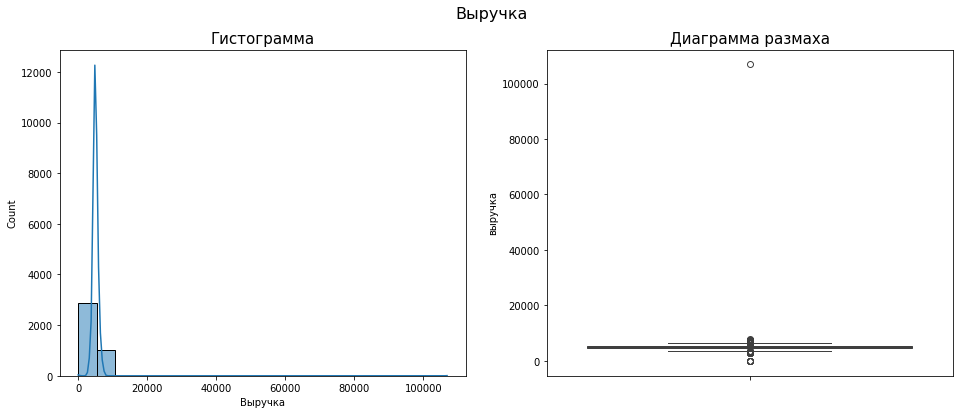

In [44]:
box_hist_plot(money, 'выручка', 'Выручка')

Видим выброс, проанализируем:

In [45]:
print(money[money['выручка'] > 100000])

        id         период   выручка
98  215380  текущий_месяц  106862.2


Выручка за текущий месяц в размере более 100000.00 рублей при среднем показателе 5000.00 выглядит выбросом. Запомним данные этого покупателя и обработаем при объединении таблиц.

Посмотрим,сеть ли покупатели, которые ничего не покупали: 

In [46]:
worst_buy = money[money['выручка'] == 0]
print(worst_buy)

        id               период  выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0


У нас всего три покупателя с id = 215348, 215357, 215359 которые в предыдущий месяц вообще ничего не купили из 1300. Удалим этих покупателей после объединения таблиц.

#### time

In [47]:
time.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

In [48]:
time.describe()

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

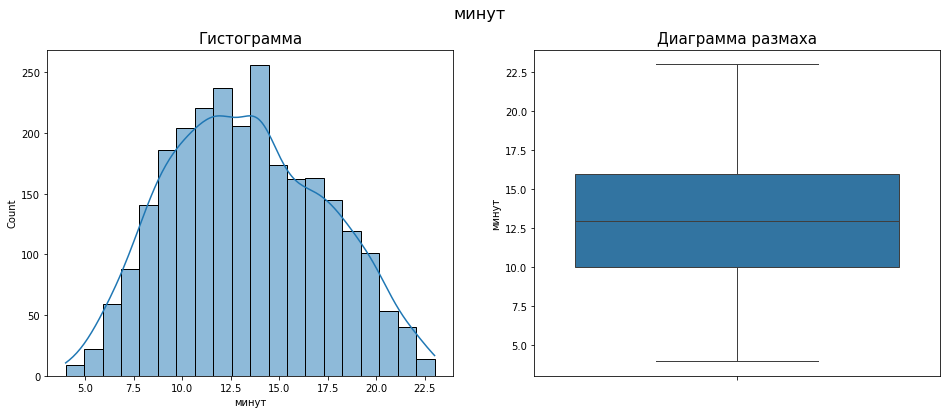

In [49]:
box_hist_plot(time, 'минут', 'минут')

В среднем клиент проводит 13 минут на сайте. Распределение нормальное.

#### profit

In [50]:
profit.describe()

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

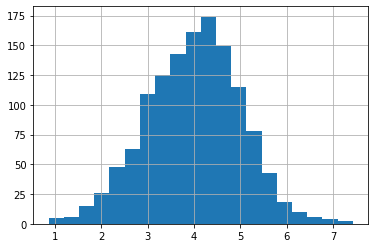

In [51]:
profit['прибыль'].hist(bins = 20);

#### Вывод: Исследовательский анализ проведен по значениям в прдеставленных данных

1. Покупателей с низкой покупательской активностью меньше, чем покупателей с прежним уровнем активности
2. Премиум сервис у меньшего количества покупателей (около 30% покупателей)
3. Все покупатели зарегистрированы более 100 дней, среднее количество покупателей зарегистрировано около 600 дней, встречаются и те, кто зарегистрирован более 1000 дней, но их не много. 
4. В большинстве случаев продукты по акции при покупке составляют 20-30% от заказа.
5. Больше всего покупают товары для детей, Домашний текстиль и косметику/аксессуары. Самая низко продаваемая категория среди представленных - кухонная посуда.
6. Покупатель смотрит 2-3 категории за визит в течение последнего месяца. Одну категорию вероятно смотрят те, кто знает, что именно надо купить, а 6 категорий интересны для тех, кто зашел "посмотреть" - их меньше всех.
7. Количество неоплаченных продуктов составляет 1-3 единицы за квартал у клиента.
8. Сбои в количестве 4 раз коснулись покупателя во время посещения сайта - самый распространенный показатель ошибок сервиса. Расстраивает, что есть показатели и в 8-9 ошибок. Количество посетителей с такими данными мало, но это знак на то, что над техническим сопровождением надо работать, так как ошибки сервиса раздражают обычно покупателя. Таким образом теряются клиенты и отзывы о работе сервиса не будут положительными.
9. В среднем покупатель за один визит просматривает от 3 до 12 страниц в течение последнего месяца.

### Объединение таблиц

In [52]:
money.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [53]:
money= money.pivot_table(money, index = 'id', columns = 'период')
money.columns = money.columns.droplevel(0)
money.head()

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215348               0.0                  0.0         3293.1
215349            5216.0               4472.0         4971.6
215350            5457.5               4826.0         5058.4
215351            6158.0               4793.0         6610.4
215352            5807.5               4594.0         5872.5

In [54]:
money.head(5)

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215348               0.0                  0.0         3293.1
215349            5216.0               4472.0         4971.6
215350            5457.5               4826.0         5058.4
215351            6158.0               4793.0         6610.4
215352            5807.5               4594.0         5872.5

In [55]:
money.describe()

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
count        1300.000000          1300.000000    1300.000000
mean         4936.920385          4825.206923    5314.960846
std           739.597997           405.979663    2939.708156
min             0.000000             0.000000    2758.700000
25%          4496.750000          4583.000000    4706.050000
50%          5005.000000          4809.000000    5179.950000
75%          5405.625000          5053.500000    5761.725000
max          6869.500000          5663.000000  106862.200000

In [56]:
time.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

In [57]:
time = time.pivot_table(time, index = 'id', columns = 'период')
time.columns = time.columns.droplevel(0)
time = time.rename(columns={'предыдущий_месяц':'минуты_в_пред_мес','текущий_месяц':'минуты_в_тек_мес'})
time.head()

период  минуты_в_пред_мес  минуты_в_тек_мес
id                                         
215348                 13                14
215349                 12                10
215350                  8                13
215351                 11                13
215352                  8                11

In [58]:
time_money = time.merge(money, on = 'id', how = 'left')
time_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   минуты_в_пред_мес    1300 non-null   int64  
 1   минуты_в_тек_мес     1300 non-null   int64  
 2   предыдущий_месяц     1300 non-null   float64
 3   препредыдущий_месяц  1300 non-null   float64
 4   текущий_месяц        1300 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 60.9 KB


In [59]:
data = customer.merge(time_money, on = 'id', how = 'left')

In [60]:
data.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                         1300.000000     1300.000000       1300.000000   
mean                             2.840000        4.185385          8.176923   
std                              1.971451        1.955298          3.978126   
min                              0.000000        0.000000          1.000000   
25%                              1.000000        3.000000          5.000000   
50%                              3.000000        4.000000          8.000000   
75%                              4.000000        6.000000         11.000000   
max                             10.000000        9.000000         20.000000   

       минуты_в_пред_мес  минуты_в_тек_мес  предыдущий_месяц  \
count        1300.000000       1300.000000       1300.000000   
mean           13.467692         13.204615       4936.920385   
std             3.932029          4.220589        739.597997   
min             5.000000          4.000000          0.000000   
25%            11.000000         10.000000       4496.750000   
50%            13.000000         13.000000       5005.000000   
75%            17.000000         16.000000       5405.625000   
max            23.000000         23.000000       6869.500000   

       препредыдущий_месяц  текущий_месяц  
count          1300.000000    1300.000000  
mean           4825.206923    5314.960846  
std             405.979663    2939.708156  
min               0.000000    2758.700000  
25%            4583.000000    4706.050000  
50%            4809.000000    5179.950000  
75%            5053.500000    5761.725000  
max            5663.000000  106862.200000

In [61]:
data.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                         1300.000000     1300.000000       1300.000000   
mean                             2.840000        4.185385          8.176923   
std                              1.971451        1.955298          3.978126   
min                              0.000000        0.000000          1.000000   
25%                              1.000000        3.000000          5.000000   
50%                              3.000000        4.000000          8.000000   
75%                              4.000000        6.000000         11.000000   
max                             10.000000        9.000000         20.000000   

       минуты_в_пред_мес  минуты_в_тек_мес  предыдущий_месяц  \
count        1300.000000       1300.000000       1300.000000   
mean           13.467692         13.204615       4936.920385   
std             3.932029          4.220589        739.597997   
min             5.000000          4.000000          0.000000   
25%            11.000000         10.000000       4496.750000   
50%            13.000000         13.000000       5005.000000   
75%            17.000000         16.000000       5405.625000   
max            23.000000         23.000000       6869.500000   

       препредыдущий_месяц  текущий_месяц  
count          1300.000000    1300.000000  
mean           4825.206923    5314.960846  
std             405.979663    2939.708156  
min               0.000000    2758.700000  
25%            4583.000000    4706.050000  
50%            4809.000000    5179.950000  
75%            5053.500000    5761.725000  
max            5663.000000  106862.200000

In [62]:
data.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 снизилась     премиум                 да   
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   минуты_в_пред_мес  минуты_в_тек_мес  предыдущий_месяц  препредыдущий_месяц  \
0                 13                14               0.0                  0.0   
1                 12                10            5216.0               4472.0   
2                  8                13            5457.5               4826.0   
3                 11                13            6158.0               4793.0   
4                  8                11            5807.5               4594.0   

   текущий_месяц  
0         3293.1  
1         4971.6  
2         5058.4  
3         6610.4  
4         5872.5

Удалим из объединенной таблицы трех покупателей, которые ничего не приобрели в два предыдущих месяца и откорректируем выброс, заменив его на среднее значение по предыдущим месяцам.

In [63]:
data[data['id'].isin([215348, 215357, 215359, 215380])]


id покупательская_активность тип_сервиса разрешить_сообщать  \
0   215348                 снизилась     премиум                 да   
9   215357                 снизилась    стандарт                 да   
11  215359                 снизилась    стандарт                 да   
32  215380                 снизилась     премиум                нет   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                  3.4                     5           121               0.00   
9                  3.9                     5           154               0.00   
11                 4.6                     5           110               0.00   
32                 1.7                     4           637               0.94   

              популярная_категория  средний_просмотр_категорий_за_визит  \
0                 Товары для детей                                    6   
9   Техника для красоты и здоровья                                    3   
11               Домашний текстиль                                    4   
32  Техника для красоты и здоровья                                    3   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                    2               1                 5   
9                                    3               9                 5   
11                                   2               4                 2   
32                                   2               4                 7   

    минуты_в_пред_мес  минуты_в_тек_мес  предыдущий_месяц  \
0                  13                14               0.0   
9                  12                 6               0.0   
11                 13                11               0.0   
32                 12                14            6077.0   

    препредыдущий_месяц  текущий_месяц  
0                   0.0         3293.1  
9                   0.0         5986.3  
11                  0.0         4735.0  
32               5051.0       106862.2

In [64]:
data['текущий_месяц'] = data['текущий_месяц'].replace(106862.2, 5564) #заменила средним значением (рассчитала вручную)

In [65]:
data = data[data['предыдущий_месяц'] > 0] #удалила не активных покупателей по 2-м предыдущим месяцам 

Вывод: Объединение таблиц произведено, выручка в текущий и предыдущий месяцы выделены в отдельные столбцы. Выброс, который может помешать последующему анализу будет удален по
. Приступаем к корреляционному анализу.

### Корреляционный анализ

Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 

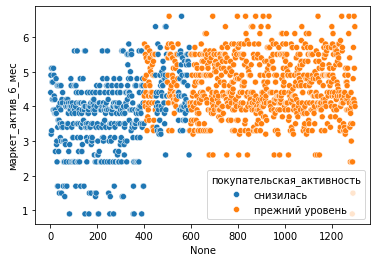

In [66]:
sns.scatterplot(data = data, x=data.index, y='маркет_актив_6_мес', hue = 'покупательская_активность')
plt.show()

Корреляция есть. Количество маркетинговых коммуникаций приходится больше на покупателей с прежней покупательской активностью, меньше - для тех, у кого покупательская активностьб снизилась (есть покупатели на которых за последние 6 месяцев приходилось маркетинговых коммуникаций в количестве 1 шт.)

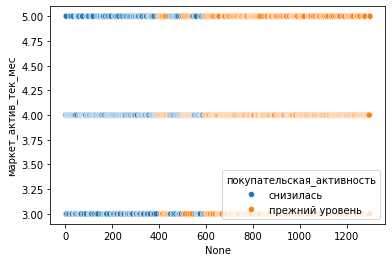

In [67]:
sns.scatterplot(data = data, x=data.index, y= 'маркет_актив_тек_мес', hue = 'покупательская_активность')
plt.show()

За последний месяц с маркетинговыми коммуникациями ситуация уравновесилась: маркетинговых коммуникаций стало больше для всех клиентов вне зависимости от уровня активности. Корреляции не наблюдаем.

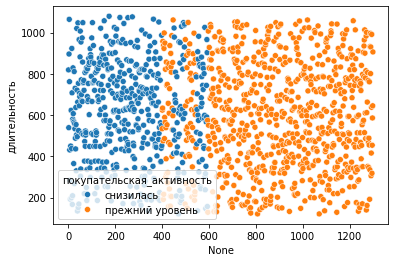

In [68]:
sns.scatterplot(data = data, x=data.index, y= 'длительность', hue = 'покупательская_активность')
plt.show()

Корреляция есть. По графику можно сказать, что постоянные клиенты (которые с компанией дольше всего) держат прежний уровень покупательской активности, у "новых" покупателей чаще всего снижается покупательская активность. 

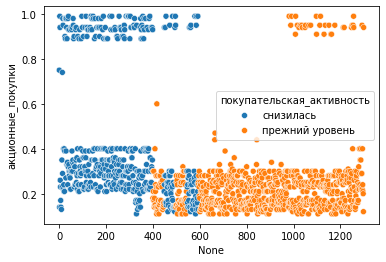

In [69]:
sns.scatterplot(data = data, x=data.index, y= 'акционные_покупки', hue = 'покупательская_активность')
plt.show()

Корреляция наблюдается хорошая. Доля акционных покупок в большем количестве у покупателей с низкой покупательской активностью, однако у покупателей с прежней покупательской активностью доля покупок по акциям составляет от 10 до 30 %. 

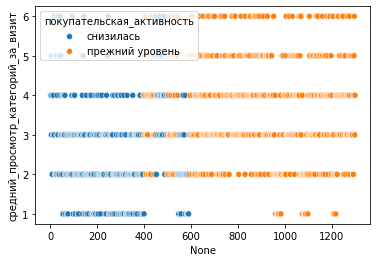

In [70]:
sns.scatterplot(data = data, x=data.index, y= 'средний_просмотр_категорий_за_визит', hue = 'покупательская_активность')
plt.show()

Корреляция есть. Покупатели с прежним уровнем активности просматривают большее количество категорий за визит чем, покупатели со сниженной активностью. Такие покупатели за визит просматривают чаще 4 категории напротив с прежним уровнем активности покупатели за визит просматривают 6 категорий.

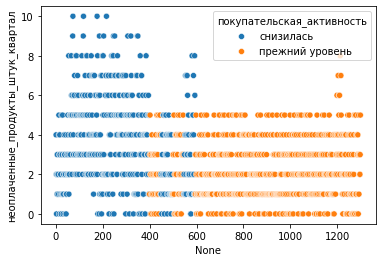

In [71]:
sns.scatterplot(data = data, x=data.index, y= 'неоплаченные_продукты_штук_квартал', hue = 'покупательская_активность')
plt.show()

Корреляция высокая. большая доля неоплаченных продуктов приходится на покупателей со сниженной активностью.

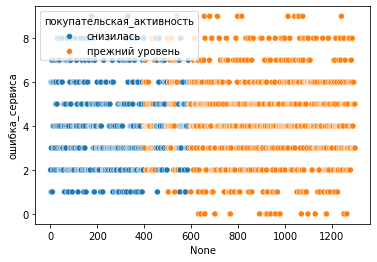

In [72]:
sns.scatterplot(data = data, x=data.index, y= 'ошибка_сервиса', hue = 'покупательская_активность')
plt.show()

Корреляция очень слабая.

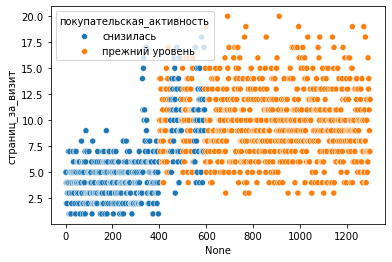

In [73]:
sns.scatterplot(data = data, x=data.index, y= 'страниц_за_визит', hue = 'покупательская_активность')
plt.show()

Наблюдаем очень высокую корреляцию. Клиентс с прежней покупательской активностью просматривает на порядок страниц большей, чнм клиент со сниженной активностью. 

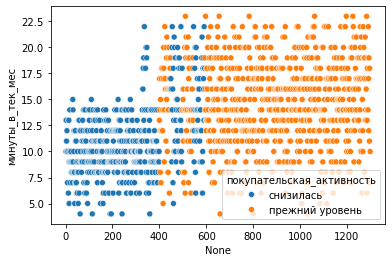

In [74]:
sns.scatterplot(data = data, x=data.index, y= 'минуты_в_тек_мес', hue = 'покупательская_активность')
plt.show()

Корреляция высокая, клиент с покупательской активностью больше провел с "компанией" минут в текущем месяце. Отностильено предыдущего месяца, в этом - все клиенты больше стали проводить время на сайте. 

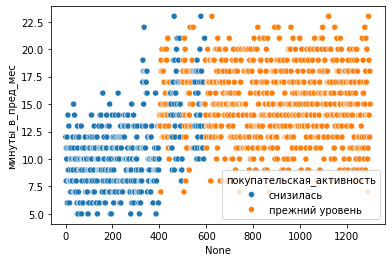

In [75]:
sns.scatterplot(data = data, x=data.index, y= 'минуты_в_пред_мес', hue = 'покупательская_активность')
plt.show()

Корреляцию наблюдаем высокую.

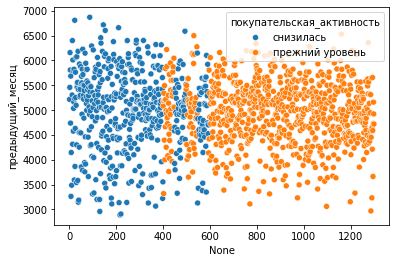

In [76]:
sns.scatterplot(data = data, x=data.index, y= ('предыдущий_месяц'), hue = 'покупательская_активность')
plt.show()

Корреляции сильной не наблюдаем.

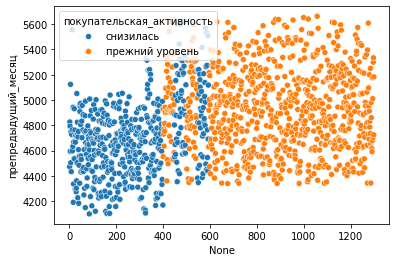

In [77]:
sns.scatterplot(data = data, x=data.index, y= ('препредыдущий_месяц'), hue = 'покупательская_активность')
plt.show()

Корреляции сильной нет.

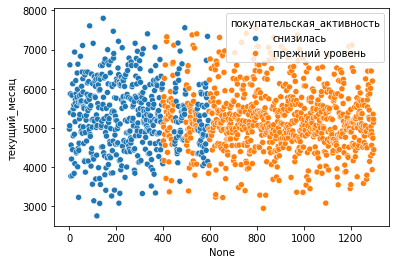

In [78]:
sns.scatterplot(data = data, x=data.index, y= ('текущий_месяц'), hue = 'покупательская_активность')
plt.show()

Корреляции сильной нет.

Перед выводом общей корреляционной зависимости, удалим столбец с "id".

In [79]:
data_c= data.drop('id', axis=1)

In [80]:
data_c.corr(method='spearman')

маркет_актив_6_мес  маркет_актив_тек_мес  \
маркет_актив_6_мес                             1.000000              0.061697   
маркет_актив_тек_мес                           0.061697              1.000000   
длительность                                  -0.044614             -0.131979   
акционные_покупки                             -0.277968              0.033045   
средний_просмотр_категорий_за_визит            0.185027             -0.025158   
неоплаченные_продукты_штук_квартал            -0.134368              0.061754   
ошибка_сервиса                                 0.038656              0.087351   
страниц_за_визит                               0.319918              0.003144   
минуты_в_пред_мес                              0.274003              0.013538   
минуты_в_тек_мес                               0.226345             -0.063044   
предыдущий_месяц                              -0.005652             -0.027107   
препредыдущий_месяц                            0.233325             -0.039397   
текущий_месяц                                  0.001213             -0.011767   

                                     длительность  акционные_покупки  \
маркет_актив_6_мес                      -0.044614          -0.277968   
маркет_актив_тек_мес                    -0.131979           0.033045   
длительность                             1.000000           0.029186   
акционные_покупки                        0.029186           1.000000   
средний_просмотр_категорий_за_визит     -0.043150          -0.203380   
неоплаченные_продукты_штук_квартал      -0.108822           0.197624   
ошибка_сервиса                           0.103528          -0.051590   
страниц_за_визит                        -0.034591          -0.370853   
минуты_в_пред_мес                       -0.124000          -0.332743   
минуты_в_тек_мес                         0.083035          -0.274693   
предыдущий_месяц                         0.013739           0.007035   
препредыдущий_месяц                     -0.039284          -0.267790   
текущий_месяц                            0.015123           0.023051   

                                     средний_просмотр_категорий_за_визит  \
маркет_актив_6_мес                                              0.185027   
маркет_актив_тек_мес                                           -0.025158   
длительность                                                   -0.043150   
акционные_покупки                                              -0.203380   
средний_просмотр_категорий_за_визит                             1.000000   
неоплаченные_продукты_штук_квартал                             -0.251448   
ошибка_сервиса                                                  0.010034   
страниц_за_визит                                                0.267536   
минуты_в_пред_мес                                               0.148376   
минуты_в_тек_мес                                                0.233358   
предыдущий_месяц                                               -0.049596   
препредыдущий_месяц                                             0.149619   
текущий_месяц                                                  -0.070818   

                                     неоплаченные_продукты_штук_квартал  \
маркет_актив_6_мес                                            -0.134368   
маркет_актив_тек_мес                                           0.061754   
длительность                                                  -0.108822   
акционные_покупки                                              0.197624   
средний_просмотр_категорий_за_визит                           -0.251448   
неоплаченные_продукты_штук_квартал                             1.000000   
ошибка_сервиса                                                -0.098544   
страниц_за_визит                                              -0.165297   
минуты_в_пред_мес                                             -0.183426   
минуты_в_тек_мес                                              -0.214803   
пре

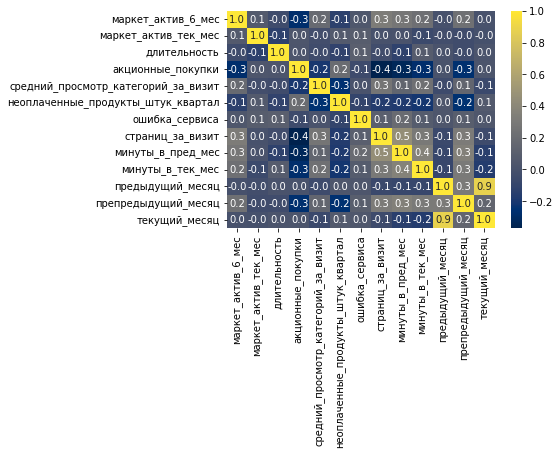

In [81]:
sns.heatmap(data_c.corr(method='spearman'), annot=True, fmt='.1f', cmap='cividis') 
plt.show()

Наблюдается сильная положительная корреляция между выручкой предыдущего и текущего месяца (коэффициент корреляции 0.84).

Есть незначительная положительная корреляция между количеством минут за предыдущий месяц и количеством страниц за визит (коэффициент корреляции 0.5), а также между количеством минут за предыдущий месяц и количеством минут за текущий месяц (коэффициент корреляции 0.4).

Есть незначительная отрицательная корреляция между среднемесячной долей покупок по акции от общего числа покупок за последние 6 месяцев и количеством страниц за визит (коэффициент корреляции -0.4). Теперь рассмотрим корреляцию параметров c помощью другого метода, который справляется и с категориальными параметрами.

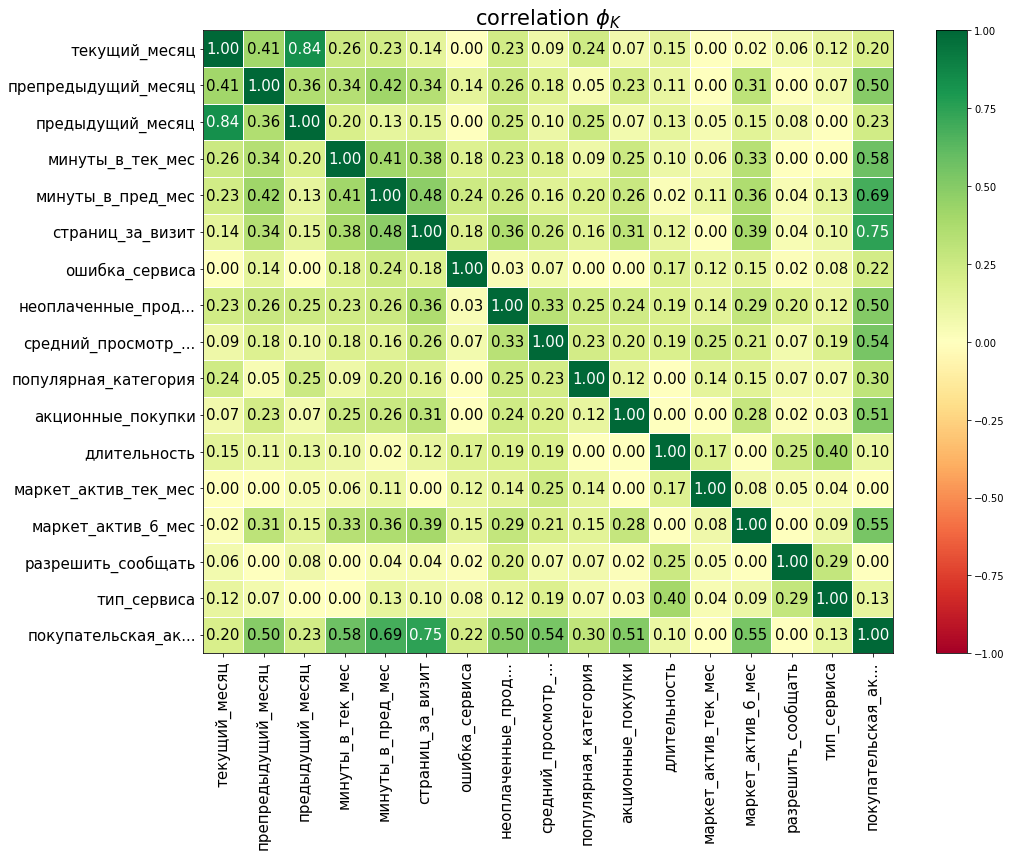

In [82]:
# список интервальных признаков
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_в_тек_мес', 'минуты_в_пред_мес', 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data_c.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Вывод: Мультиколлинеарности нет, поэтому оставим все признаки для модели.

### Использование пайплайнов

In [83]:
data_c.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
1                 снизилась     премиум                 да   
2                 снизилась    стандарт                нет   
3                 снизилась    стандарт                 да   
4                 снизилась    стандарт                нет   
5                 снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   
5    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   
5                                   1               1                 4   

   минуты_в_пред_мес  минуты_в_тек_мес  предыдущий_месяц  препредыдущий_месяц  \
1                 12                10            5216.0               4472.0   
2                  8                13            5457.5               4826.0   
3                 11                13            6158.0               4793.0   
4                  8                11            5807.5               4594.0   
5                 10                10            4738.5               5124.0   

   текущий_месяц  
1         4971.6  
2         5058.4  
3         6610.4  
4         5872.5  
5         5388.5

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    data_c.drop(
        [
           'покупательская_активность'
        ], 
            axis=1
    ),
    data_c['покупательская_активность'],
    test_size = TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify = data_c['покупательская_активность']
) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(972, 16)
(325, 16)
(972,)
(325,)


In [85]:
# нужно кодировать с помощью OneHotEncoder
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
# нужно кодировать с помощью OrdinalEncoder
ord_columns = ['тип_сервиса']
# нужно масштабировать
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_в_тек_мес', 'минуты_в_пред_мес', 'препредыдущий_месяц', 'предыдущий_месяц']

In [86]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        ('ohe', 
         OneHotEncoder(handle_unknown='error', sparse_output = False, drop='first')
        )
    ]
 )

In [87]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories = [
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


In [88]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [89]:
# создайте итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier())
    ]
)

In [90]:
# зададим гиперпараметры и методы масштабирования для каждой модели:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, 
            solver='saga', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
]

Для оценки выбрала ROC-AUC в качестве основной метрики, так как задача требует баланса между обнаружением положительных случаев и минимизацией ложных срабатываний. Данная метрика позволяет оценить качество модели независимо от порога классификации, что важно для дальнейшей настройки.

In [91]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_)
print ('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means 

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                             

In [92]:
pd.set_option('display.max_colwidth', None)

In [93]:
# первые 10 моделей с наилучшим значением метрики
result = pd.DataFrame(randomized_search.cv_results_)
display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

rank_test_score  \
8                1   
5                2   
1                3   
9                4   
4                5   
6                6   
0                7   
3                8   
7                9   
2               10   

                                                       param_models  \
8                           DecisionTreeClassifier(random_state=42)   
5                           DecisionTreeClassifier(random_state=42)   
1                           DecisionTreeClassifier(random_state=42)   
9                                            KNeighborsClassifier()   
4                           DecisionTreeClassifier(random_state=42)   
6                                            KNeighborsClassifier()   
0                                            KNeighborsClassifier()   
3  LogisticRegression(penalty='l1', random_state=42, solver='saga')   
7  LogisticRegression(penalty='l1', random_state=42, solver='saga')   
2  LogisticRegression(penalty='l1', random_state=42, solver='saga')   

   mean_test_score  \
8         0.847080   
5         0.829494   
1         0.820749   
9         0.748802   
4         0.744741   
6         0.564701   
0         0.554313   
3         0.472504   
7         0.459890   
2         0.459868   

                                                                                                                                params  
8                     {'preprocessor__num': MinMaxScaler(), 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}  
5                      {'preprocessor__num': 'passthrough', 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}  
1                     {'preprocessor__num': MinMaxScaler(), 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}  
9                                     {'preprocessor__num': 'passthrough', 'models__n_neighbors': 6, 'models': KNeighborsClassifier()}  
4                   {'preprocessor__num': StandardScaler(), 'models__max_depth': 1, 'models': DecisionTreeClassifier(random_state=42)}  
6                                  {'preprocessor__num': StandardScaler(), 'models__n_neighbors': 5, 'models': KNeighborsClassifier()}  
0                                    {'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 5, 'models': KNeighborsClassifier()}  
3  {'preprocessor__num': StandardScaler(), 'models__C': 7, 'models': LogisticRegression(penalty='l1', random_state=42, solver='saga')}  
7    {'preprocessor__num': MinMaxScaler(), 'models__C': 5, 'models': LogisticRegression(penalty='l1', random_state=42, solver='saga')}  
2    {'preprocessor__num': MinMaxScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='saga')}

In [94]:
# сделаем расчет метрики на тестовых данных
y_test_prob = randomized_search.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_test_prob[:,1])
print('Метрика ROC-AUC на тестовой выборке:', roc_auc.round(3))

Метрика ROC-AUC на тестовой выборке: 0.862


Провела машинное обучение, случайным образом выбирая модели и гиперпараметры. Самой лучшей моделью оказалась модель логистической регрессии с гиперпараметром С=1. Метрика на тестовой выборке для нее равна 0.862.

Теперь можем приступить к анализу важности признаков

### Анализ важности признаков

In [95]:
X_transformed = randomized_search.best_estimator_['preprocessor'].transform(X_train)
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

In [96]:
best_model = randomized_search.best_estimator_.named_steps['models']

In [97]:
explainer = shap.Explainer(best_model, X_transformed)

In [98]:
shap_values = explainer(X_transformed[:20])

In [99]:
shap_values = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=feature_names  # Передаем названия признаков
)

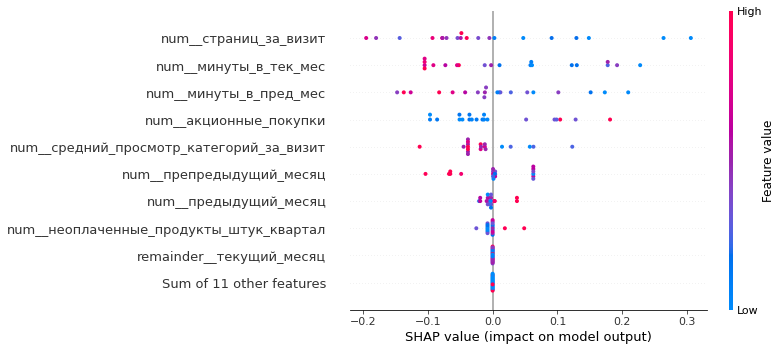

In [100]:
if len(shap_values.shape) == 3:
    shap.plots.beeswarm(shap_values[...,1])  # Класс 1
else:
    shap.plots.beeswarm(shap_values)

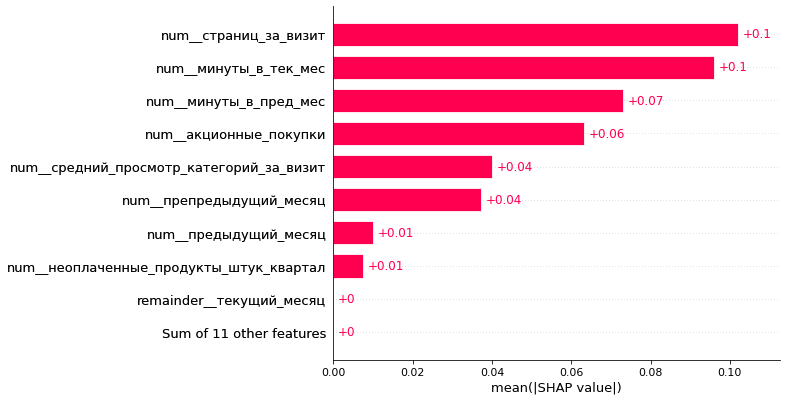

In [101]:
shap.plots.bar(shap_values[:,:,1]) 

#### Вывод

Для модели выжны следующие признаки это: Акционные покупки, Просмотр категорий за визит, Страниц за визит, Минуты в предыдущий месяц, Минуты в текущий месяц.

Малозначимыми признаками оказались:Популярная категория, Маркет_актив_тек_мес, Разрешить сообщать, Тип_сервиса.

По графику beeswarm видно:

ord_акционные_покупки_категория: Высокие значения этого признака увеличивают SHAP значения и, следовательно, увеличивают вероятность того, что покупательная активность снизится. Это означает, что наличие акционных покупок больше связано со снижением покупательной активности.

num_средний_просмотр_категорий_за_визит  и num_страницы_за_визит : Низкие значения этих признаков увеличивают SHAP значения, что указывает на увеличение вероятности снижения покупательной активности. То есть чем меньше человек просмотрит категорий и посетит страниц за визит, тем выше вероятность того, что его покупательная активность снизится.

num_минут_текущий_месяц и num_минут_предыдущий_месяц: Эти признаки имеют смешанное влияние, где высокие значения могут как увеличивать, так и уменьшать вероятность целевого события, в зависимости от конкретного случая.

Остальные признаки также имеют влияние, но оно менее выражено.

### Сегментация покупателей

In [102]:
data = data.merge(profit, on='id')

In [103]:
data.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 снизилась     премиум                 да   
1  215350                 снизилась    стандарт                нет   
2  215351                 снизилась    стандарт                 да   
3  215352                 снизилась    стандарт                нет   
4  215353                 снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   минуты_в_пред_мес  минуты_в_тек_мес  предыдущий_месяц  препредыдущий_месяц  \
0                 12                10            5216.0               4472.0   
1                  8                13            5457.5               4826.0   
2                 11                13            6158.0               4793.0   
3                  8                11            5807.5               4594.0   
4                 10                10            4738.5               5124.0   

   текущий_месяц  прибыль  
0         4971.6     4.16  
1         5058.4     3.13  
2         6610.4     4.87  
3         5872.5     4.21  
4         5388.5     3.95

In [104]:
# Получение предсказанных вероятностей для класса 'снизилась'
y_pred_proba = randomized_search.best_estimator_.predict_proba(
    data.drop('покупательская_активность', axis=1)
)[:, 1]  # Индекс 1, если 'снизилась' второй в classes_

data['вероятность_снижения'] = y_pred_proba

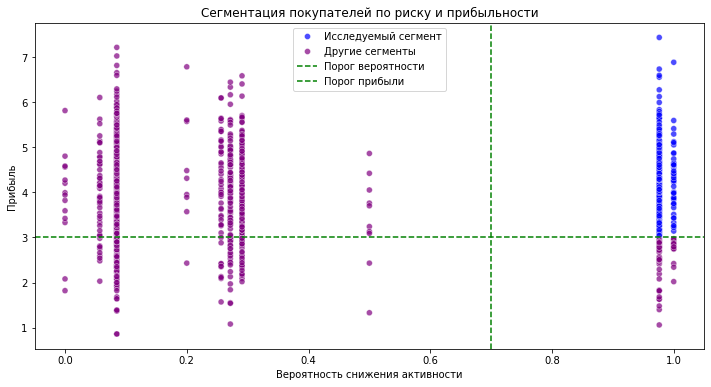

                     вероятность_снижения   прибыль  Количество
сегмент                                                        
Другие сегменты                  0.205442  3.910704         995
Исследуемый сегмент              0.980054  4.283940         302


In [105]:
# Создаем метки сегментов
data['сегмент'] = np.where(
    (data['вероятность_снижения'] >= 0.7) & 
    (data['прибыль'] > 3), 
    'Исследуемый сегмент', 
    'Другие сегменты'
)

# Визуализация
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=data,
    x='вероятность_снижения',
    y='прибыль',
    hue='сегмент',
    palette={'Исследуемый сегмент': 'blue', 'Другие сегменты': 'purple'},
    alpha=0.7
)

plt.axvline(x=0.7, color='green', linestyle='--', label='Порог вероятности')
plt.axhline(y=3, color='green', linestyle='--', label='Порог прибыли')
plt.title('Сегментация покупателей по риску и прибыльности')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.legend()
plt.show()

# Статистика по сегментам
segment_stats = data.groupby('сегмент').agg({
    'вероятность_снижения': 'mean',
    'прибыль': 'mean',
    'id': 'count'
}).rename(columns={'id': 'Количество'})

print(segment_stats)

In [106]:
data.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 снизилась     премиум                 да   
1  215350                 снизилась    стандарт                нет   
2  215351                 снизилась    стандарт                 да   
3  215352                 снизилась    стандарт                нет   
4  215353                 снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  ...  \
0     Товары для детей                                    4  ...   
1    Домашний текстиль                                    5  ...   
2     Товары для детей                                    5  ...   
3     Товары для детей                                    3  ...   
4    Домашний текстиль                                    4  ...   

   ошибка_сервиса  страниц_за_визит  минуты_в_пред_мес  минуты_в_тек_мес  \
0               2                 5                 12                10   
1               1                 5                  8                13   
2               6                 4                 11                13   
3               3                 2                  8                11   
4               1                 4                 10                10   

   предыдущий_месяц  препредыдущий_месяц  текущий_месяц  прибыль  \
0            5216.0               4472.0         4971.6     4.16   
1            5457.5               4826.0         5058.4     3.13   
2            6158.0               4793.0         6610.4     4.87   
3            5807.5               4594.0         5872.5     4.21   
4            4738.5               5124.0         5388.5     3.95   

   вероятность_снижения              сегмент  
0               0.97619  Исследуемый сегмент  
1               0.97619  Исследуемый сегмент  
2               0.97619  Исследуемый сегмент  
3               0.97619  Исследуемый сегмент  
4               0.20000      Другие сегменты  

[5 rows x 21 columns]

In [107]:
def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)

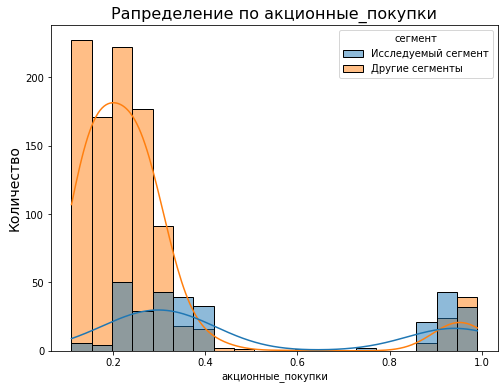

In [108]:
histogram(data, 'акционные_покупки', 'сегмент')

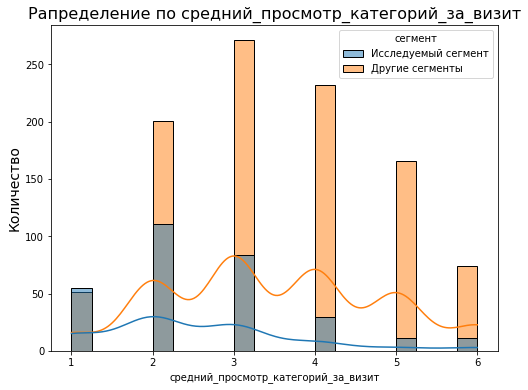

In [109]:
histogram(data, 'средний_просмотр_категорий_за_визит', 'сегмент')

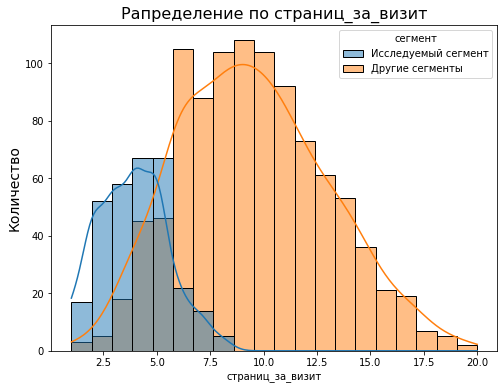

In [110]:
histogram(data, 'страниц_за_визит', 'сегмент')

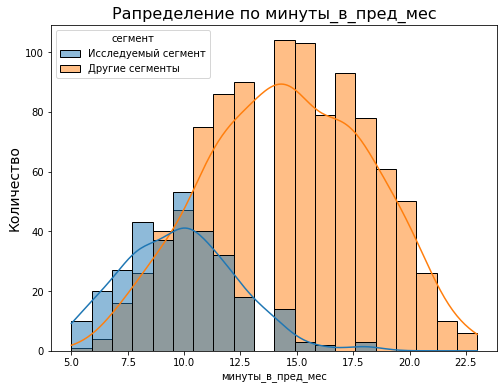

In [111]:
histogram(data, 'минуты_в_пред_мес', 'сегмент')

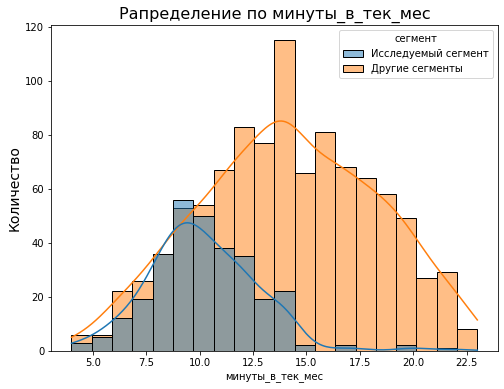

In [112]:
histogram(data, 'минуты_в_тек_мес', 'сегмент')

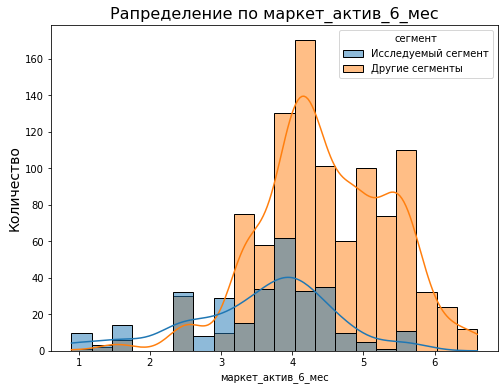

In [113]:
histogram(data, 'маркет_актив_6_мес', 'сегмент')

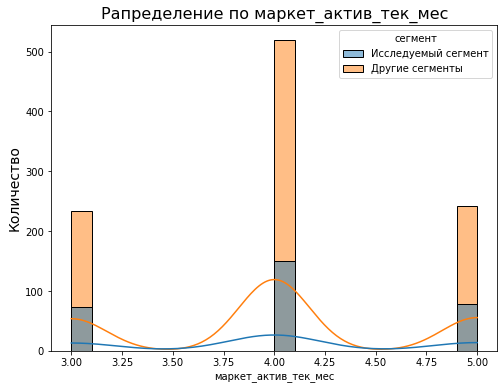

In [114]:
histogram(data, 'маркет_актив_тек_мес', 'сегмент')

In [115]:
def categoral_unique(df, col):
    display(df[col].unique())
    value_counts = df[col].value_counts()
    plt.figure(figsize=(8,8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

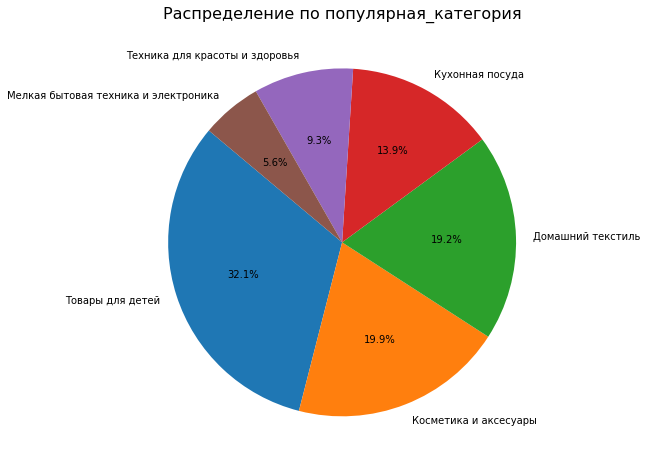

In [116]:
categoral_unique(data[data['сегмент'] == 'Исследуемый сегмент'], 'популярная_категория')

array(['премиум', 'стандарт'], dtype=object)

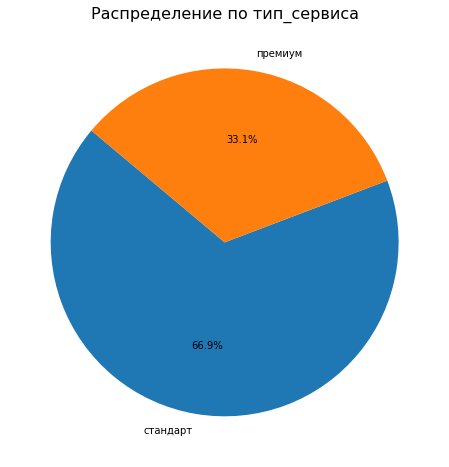

In [118]:
categoral_unique(data[data['сегмент'] == 'Исследуемый сегмент'], 'тип_сервиса')

#### Итоги
Мы рассмотрели сегментацию покупателей по двум параметрам - прибыль от покупателя за последние 3 месяца превышает 3, вероятность снижения = 0.7. Исследуемый сегмент 302 покупателя.

Для этой группы покупателей мы рассмотрели статистику ранее определенных ключевых параметров - тех, которые наиболее сильно влияют на результат предсказания целевого показателя "активность" покупателя.

Средние значения параметров "страниц за визит" и "количество минут на сайте" для выбранного сегмента покупателей ниже средних значений этих параметров для всех покупателей.

Среднее значения параметра "акционные покупки" для выбранного сегмента покупателей ниже среднего этого параметра для всех покупателей, для этих покупателей гонка за покупками по акциям не интересна. Скорее такие пользователи 

Среднее количество коммуникаций за последние 6 месяцев для выбранного сегмента покупателей такое же, как и для всех покупателей.

Что предлагается сделать, чтобы увеличить активность покупателей из рассматриваемого сегмента.

Надо увеличить количество коммуникаций с ними (с теми из них, кто разрешает коммуникации). При этом это должны быть предложения любого характера, кроме акционных предложений со снижением цен. Например, можно предлагать акцию на наботы товаров, а не на отдельные товары со сниженным предложением цены. Это приведет к увеличению значений параметров "страниц за визит" и "количество минут на сайте", которые положительно влияют на показатель активности покупателей и возможно приведет к уменьшению доли акционных покупок.

### Общий вывод

В данном проекте были рассмотрены данные о покупателях интернет-магазина, их поведении на сайте магазина и их покупках. Объем данных был представлен в четырех таблицах.

Цель проекта - научиться предсказывать активность покупателей в последующие месяцы, вероятность ее снижения. Также нужно было выбрать сегмент покупателей, проанализировать его и предложить меры по повышению вероятности того, что активность покупателей из данного сегмента не снизится.

1. Что было сделано на этапе предобработки.
    Приведены названия столбцов всех данных к нижнему регистру. В таблице customer произведена замена типа сервиса 'стандартт' на 'стандарт' из-за опечатки в данных, исправлены 'Косметика и аксесуары' в 'косметика и аксессуары'. В столбце 'покупательская_активность'  все уникальные значения привела к нижнему регистру для удобства восприятия. Пропущенных данных и дубликатов не обнаружено. В таблице money обнаружены 5 явных дубликатов, которые в последствие удалены. Пропущенных данных не выявлено. В таблице time сделана замена данных в столбце 'Период' - 'предыдцщий_месяц' на 'предыдущий_месяц' из-за опечатки в данных. Пропуски и дубликаты в таблице не обнаружены.  В таблице  profit в столбце 'Прибыль' поменяла тип данных. Пропущенных данных и дубликатов не обнаружено.

2. Результаты исследовательского анализа.
-Покупателей с низкой покупательской активностью меньше, чем покупателей с прежним уровнем активности

-Премиум сервис у меньшего количества покупателей (около 30% покупателей)

-Все покупатели зарегистрированы более 100 дней, среднее количество покупателей зарегистрировано около 600 дней, встречаются и те, кто зарегистрирован более 1000 дней, но их не много. 

-В большинстве случаев продукты по акции при покупке составляют 20-30% от заказа.

-Больше всего покупают товары для детей, Домашний текстиль и косметику/аксессуары. Самая низко продаваемая категория среди представленных - кухонная посуда.

-Покупатель смотрит 2-3 категории за визит в течение последнего месяца. Одну категорию вероятно смотрят те, кто знает, что именно надо купить, а 6 категорий интересны для тех, кто зашел "посмотреть" - их меньше всех.

-Количество неоплаченных продуктов составляет 1-3 единицы за квартал у клиента.

-Сбои в количестве 4 раз коснулись покупателя во время посещения сайта - самый распространенный показатель ошибок сервиса. Расстраивает, что есть показатели и в 8-9 ошибок. Количество посетителей с такими данными мало, но это знак на то, что над техническим сопровождением надо работать, так как ошибки сервиса раздражают обычно покупателя. Таким образом теряются клиенты и отзывы о работе сервиса не будут положительными.

-В среднем покупатель за один визит просматривает от 3 до 12 страниц в течение последнего месяца.

Для дальнейшей работы данные объединили в итоговую таблицу и оставили параметры только 1296 покупателей, ежемесячная выручка от которых за последние 3 месяца была больше 0.

3. Корреляционный анализ.

Провели корреляционный анализ. Обнаружили высокую коллинеарность между параметрами "выручка_предыдущий_период" и "выручка_текущий_период". Исключили последний параметр из данных для машинного обучения.

4. Машинное обучение.

Провели машинное обучение, случайным образом выбирая из четырех типов моделей (KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()) и их гиперпараметров. Также меняли способ масштабирования данных (скейлер) на этапе их подготовки перед обучением моделей.

В качестве метрики для оценки качества модели использовали метрику "roc_auc". Метрику используют, когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать также в случае, когда объектов с одним значением целевого признака больше, чем с другими. У нас именно такая ситуация (активных покупателей 62%, неактивных - 38%).

Самой лучшей моделью оказалась модель логистической регрессии с гиперпараметром С=1. Метрика на тестовой выборке для нее равна 0.9.

5. Анализ важности признаков.

Провели анализ важности признаков с помощью shap.

Самый влиятельный параметр - количество просмотренных страниц за визит. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1, то есть активность покупателя останется прежней.

Менее влиятельные параметры - количество проведенных на сайте минут в предыдущем и текущем месяцах, а также доля акционных покупок и среднемесячное значение маркетинговых коммуникаций на одного покупателя.

При этом высокие значения количества проведенных на сайте минут и среднемесячного количества маркетинговых коммуникаций говорят о высокой вероятности того, что активность покупателя останется прежней.

Высокое же значение доли акционных покупок говорит о высокой вероятности того, что активность покупателя снизится.

5. Сегментация покупателей и рекомендации для выбранного сегмента.

Рассмотрели сегментацию покупателей по двум параметрам - прибыль от покупателя за последние 3 месяца превышает 5, но активность покупателя снизилась. В нашем сегменте 73 покупателя, при этом только 53 разрешают коммуникации.

Для этой группы покупателей мы рассмотрели статистику ранее определенных ключевых параметров - тех, которые наиболее сильно влияют на результат предсказания целевого показателя "активность" покупателя.

Средние значения параметров "страниц за визит" и "количество минут на сайте" для выбранного сегмента покупателей ниже средних значений этих параметров для всех покупателей.

Среднее значения параметра "акционные покупки" для выбранного сегмента покупателей наоборот выше среднего этого параметра для всех покупателей.

Среднее количество коммуникаций за последние 6 месяцев для выбранного сегмента покупателей такое же, как и для всех покупателей.

Рекомендации

Что предлагается сделать, чтобы увеличить активность покупателей из рассматриваемого сегмента.

Надо увеличить количество коммуникаций с ними (с теми из них, кто разрешает коммуникации). При этом это должны быть предложения любого характера, кроме акционных предложений со снижением цен. Например, можно предлагать акцию на наботы товаров, а не на отдельные товары со сниженным предложением цены. Это приведет к увеличению значений параметров "страниц за визит" и "количество минут на сайте", которые положительно влияют на показатель активности покупателей и возможно приведет к уменьшению доли акционных покупок.